# Bgee



In [4]:
import collections

import pandas
import seaborn
import matplotlib.pyplot as plt
import IPython

%matplotlib inline

In [5]:
def get_groupby_counts(df, columns):
    """Group datagrame by columns and return the number of rows for each grouping."""
    grouped = df.groupby(columns)
    get_len = lambda df: pandas.Series({'count': len(df)})
    df = grouped.apply(get_len)
    df = df.sort('count', ascending=False)
    df = df.reset_index()
    return df

## Read and process presence of expression data

In [6]:
# Read expression
presence_df = pandas.read_table('download/Homo_sapiens_expr-simple.tsv.gz', compression='gzip')
presence_df.head()

,Gene ID,Gene name,Anatomical entity ID,Anatomical entity name,Developmental stage ID,Developmental stage name,Expression,Call quality
0,ENSG00000000003,TSPAN6,CL:0000015,male germ cell,HsapDv:0000092,human middle aged stage (human),present,poor quality
1,ENSG00000000003,TSPAN6,CL:0000019,sperm,HsapDv:0000088,human early adulthood stage (human),present,poor quality
2,ENSG00000000003,TSPAN6,CL:0000023,oocyte,HsapDv:0000087,human adult stage (human),absent,high quality
3,ENSG00000000003,TSPAN6,CL:0000083,epithelial cell of pancreas,UBERON:0000104,life cycle,present,high quality
4,ENSG00000000003,TSPAN6,CL:0000115,endothelial cell,HsapDv:0000092,human middle aged stage (human),present,poor quality


In [7]:
# Apply filters for gene presence
present_df = presence_df[
    presence_df['Call quality'].isin({'high quality', 'low quality'}) &
    presence_df['Expression'].isin({'present', 'low ambiguity'})
]

In [15]:
# Find genes present per developmental stage
stage_df = get_groupby_counts(present_df, ['Developmental stage ID', 'Developmental stage name'])
stage_df.head(12)

,Developmental stage ID,Developmental stage name,count
0,HsapDv:0000090,25-44 year-old human stage (human),886385
1,UBERON:0000104,life cycle,795802
2,HsapDv:0000092,human middle aged stage (human),767581
3,HsapDv:0000094,65-79 year-old human stage (human),407378
4,HsapDv:0000087,human adult stage (human),387225
5,HsapDv:0000089,young adult stage (human),383819
6,HsapDv:0000095,80 year-old and over human stage (human),160763
7,HsapDv:0000086,adolescent stage (human),116353
8,HsapDv:0000085,6-12 year-old child stage (human),75387
9,HsapDv:0000199,fifth LMP month human stage (human),74310


In [9]:
# Find genes present per anatomical entity
anatomy_df = get_groupby_counts(present_df, ['Anatomical entity ID', 'Anatomical entity name'])
anatomy_df.head(10)

,Anatomical entity ID,Anatomical entity name,count
0,UBERON:0000473,testis,144453
1,UBERON:0000955,brain,114977
2,UBERON:0001870,frontal cortex,110212
3,UBERON:0000178,blood,104919
4,UBERON:0002107,liver,97331
5,UBERON:0002037,cerebellum,92622
6,UBERON:0000992,female gonad,88936
7,UBERON:0001987,placenta,83013
8,UBERON:0009834,dorsolateral prefrontal cortex,82020
9,UBERON:0002048,lung,70698


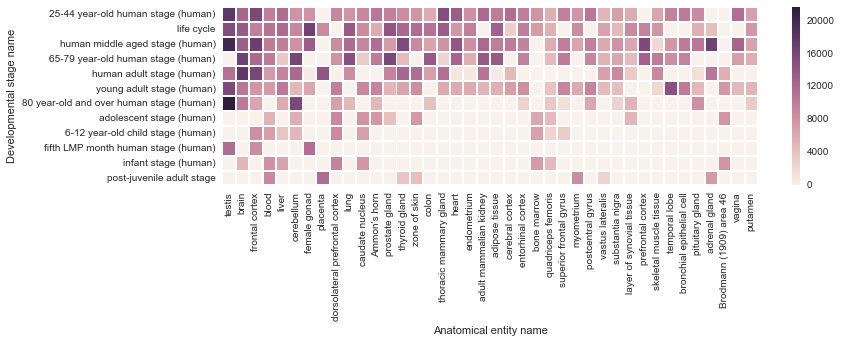

In [17]:
# Number of present genes per development stage -- anatomical entity pair
pairwise_df = get_groupby_counts(present_df, ['Developmental stage name', 'Anatomical entity name'])
rect_df = pairwise_df.pivot('Developmental stage name', 'Anatomical entity name', 'count').fillna(0)
rect_df = rect_df.loc[stage_df['Developmental stage name'][:12], anatomy_df['Anatomical entity name'][:40]]
IPython.core.pylabtools.figsize(12, 3.2)
seaborn.heatmap(rect_df);

## Read and process differential expression data

In [ ]:
# Read simple differential expression by anatomy
diffexpr_df = pandas.read_table('download/Homo_sapiens_diffexpr-anatomy-simple.tsv.gz', compression='gzip')
diffexpr_df.head()

In [ ]:
under_df = diffexpr_hq_df[diffexpr_hq_df['Differential expression'] == 'under-expression']
over_df = diffexpr_hq_df[diffexpr_hq_df['Differential expression'] == 'over-expression']

In [ ]:
collections.Counter(under_df['Developmental stage name'])

In [ ]:
collections.Counter(over_df['Developmental stage name'])

## Conversion from ensembl to entrez gene

In [ ]:
# Read Entrez Genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url)
coding_genes = set(entrez_df.GeneID[entrez_df.type_of_gene == 'protein-coding'])

# Merge with entrez gene identifiers
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/xrefs-human.tsv'
entrez_map_df = pandas.read_table(url)
entrez_map_df = entrez_map_df[entrez_map_df.resource == 'Ensembl']
entrez_map_df = entrez_map_df[['GeneID', 'identifier']].rename(columns={'identifier': 'ensembl_id'})
entrez_map_df.head()